## Loading libraries

In [ ]:
import gdown # To download the file from Google Drive
import json
import re
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import multiprocessing
from multiprocessing import Pool, cpu_count, Lock
from functools import partial
from tqdm import tqdm
from collections import Counter
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from IPython.display import display, Math

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Getting the file from GDrive

In [ ]:
file_id = '1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE
From (redirected): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE&confirm=t&uuid=51d4c285-b365-40ba-9421-b42fdaf4ca8f
To: /content/dataset.zip
100%|██████████| 1.00G/1.00G [00:19<00:00, 51.2MB/s]


'dataset.zip'

# Task 1

## File Extraction and setting path for access

In [ ]:
zip_file_path = 'dataset.zip'
extraction_dir = '/content/dataset'

os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()

    with tqdm(total=len(file_list), desc='Extracting files') as pbar:
        for file in file_list:
            zip_ref.extract(file, extraction_dir)
            pbar.update(1)

Extracting files: 100%|██████████| 56530/56530 [00:31<00:00, 1809.87it/s]


## Getting the file from GDrive

In [ ]:
file_id = '1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE
From (redirected): https://drive.google.com/uc?id=1fxAEZNVY0zXhJaGyzEw6BzDuUjvkiHXE&confirm=t&uuid=51d4c285-b365-40ba-9421-b42fdaf4ca8f
To: /content/dataset.zip
100%|██████████| 1.00G/1.00G [00:19<00:00, 51.2MB/s]


'dataset.zip'

In [ ]:
# Listing all files in the dataset directory
file_list = []
for root, dirs, files in os.walk('dataset'):
    for file in files:
        if not file.endswith('.swp'): # .swp is not of our use
            file_list.append(os.path.join(root, file))

print(f"Found {len(file_list)} files.")

Found 56528 files.


## Here we check if all the json-encoded files have the same relevant keys

In [ ]:
# Based on observations of json-encoded text format we extract the relevant keys
def extract_keys(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        metadata_keys = [k for k in data.get('metadata', {}).keys() if k != 'authors']
        other_keys = [k for k in data if k not in {'metadata', 'paper_id'}]
        return file_path, metadata_keys, other_keys
    except Exception as e:
        return file_path, str(e), str(e)

def process_files(file_list):
    with Pool(min(4, os.cpu_count())) as pool:
        return pool.map(extract_keys, file_list)

df = pd.DataFrame(process_files(file_list), columns=['File Path', 'Metadata Keys', 'Other Keys'])

df['Combined Keys'] = df.apply(lambda row: frozenset(row['Metadata Keys']) | frozenset(row['Other Keys']), axis=1)

In [ ]:
print(f"{'All relevant keys are the same.' if df['Combined Keys'].nunique() == 1 else 'Not all relevant keys are the same.'}\n{df.drop(columns=['File Path']).iloc[0]['Combined Keys']}")

All relevant keys are the same.
frozenset({'abstract', 'body_text', 'back_matter', 'bib_entries', 'title', 'ref_entries'})


We decide to keep only the most relevant parts, i.e., 'body_text', 'title' and 'abstract'.

## To extract relevant texts from JSON files, we consider the following format
1. The "title" is found within the "metadata" section.
2. The "abstract" contains the relevant "text" segment.
3. The "body_text" also contains the relevant "text" segment.
4. The "cite_spans" section has a "text" key, but it is not relevant for our work.

In [ ]:
extraction_dir = '/content/dataset/pdf_json'
json_files = [f for f in os.listdir(extraction_dir) if f.endswith('.json') and not f.endswith('.swp')]

# Function to process each JSON file
def process_file(file_name):
    file_path = os.path.join(extraction_dir, file_name)
    text_data = []

    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

            # Function to find "title" and "text", excluding certain contexts
            def extract_text(data):
                if isinstance(data, dict):
                    # Extract "title" if present in "metadata"
                    if 'metadata' in data:
                        metadata = data['metadata']
                        if isinstance(metadata, dict) and 'title' in metadata:
                            title = metadata['title']
                            if isinstance(title, str):
                                text_data.append(title)

                    # Extract "abstract" and "body_text" text
                    if 'abstract' in data:
                        abstract = data['abstract']
                        if isinstance(abstract, list):
                            for item in abstract:
                                if isinstance(item, dict) and 'text' in item:
                                    text = item['text']
                                    if isinstance(text, str):
                                        text_data.append(text)

                    if 'body_text' in data:
                        body_text = data['body_text']
                        if isinstance(body_text, list):
                            for item in body_text:
                                if isinstance(item, dict) and 'text' in item:
                                    text = item['text']
                                    if isinstance(text, str):
                                        text_data.append(text)

                    # Check and skip "cite_spans"
                    if 'cite_spans' in data:
                        # Skip extraction from "cite_spans"
                        return

                    for key, value in data.items():
                        extract_text(value)
                elif isinstance(data, list):
                    for item in data:
                        extract_text(item)

            extract_text(data)
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

    return text_data

# Use multiprocessing to process files in parallel
def parallel_process(files, num_workers=4):
    with multiprocessing.Pool(num_workers) as pool:
        results = list(tqdm(pool.imap(process_file, files), total=len(files)))
    return results

In [ ]:
corpus_file_path = '/content/corpus.txt'
results = parallel_process(json_files)

# Flatten the list of results and combine all text
corpus = [text for sublist in results for text in sublist]

# Save the corpus to a text file
with open('/content/dataset/corpus.txt', 'w', encoding='utf-8') as corpus_file:
    for text in corpus:
        corpus_file.write(text + '\n')

100%|██████████| 56528/56528 [00:15<00:00, 3571.01it/s]


In [ ]:
print(f"Before processing corpus size is {round(os.path.getsize('/content/dataset/corpus.txt')/(1024 ** 3),2)} GB")

Before processing corpus size is 1.4 GB


# Task 2

## Handling case-folding, removal of numbers, etc.

In [ ]:
input_file_path = '/content/dataset/corpus.txt'
output_file_path = '/content/dataset/corpus_cleaned.txt'

Here, I removed: \\
1. Texts that contain no alphabetic characters
2. Texts that include any numbers
3. Texts with greek letters
4. Punctuation marks
5. Texts that are URLs

In [ ]:
# Function to check if a token contains any alphabetic characters and no numbers
def contains_alphabet_and_no_numbers(token):
    return any(char.isalpha() for char in token) and not any(char.isdigit() for char in token)

# Function to remove tokens that do not contain any alphabetic characters and contain numbers
def remove_non_alpha_and_numbers_tokens(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if contains_alphabet_and_no_numbers(token) and not re.search(r'[\u0370-\u03FF]', token)]
    return ' '.join(filtered_tokens)

# Function to remove punctuation from the text
def remove_punctuation(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in string.punctuation]
    return ' '.join(filtered_tokens)

# Function to remove URLs from the text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

# Function to clean and process each line
def process_line(line):
    line = line.lower()
    line = remove_urls(line)
    line = remove_punctuation(line)
    cleaned_line = remove_non_alpha_and_numbers_tokens(line)

    if cleaned_line.strip():
        return cleaned_line
    return None

In [ ]:
def main():
    input_file_path = '/content/dataset/corpus.txt'
    output_file_path = '/content/dataset/corpus_cleaned.txt'

    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    with Pool(cpu_count()) as pool:
        processed_lines = list(tqdm(pool.imap(process_line, lines), total=len(lines), desc='Processing Lines'))

    with open(output_file_path, 'w') as file:
        for line in processed_lines:
            if line:
                file.write(line + '\n')

    print(f"Cleaned text has been saved to {output_file_path}.")

if __name__ == "__main__":
    main()

Processing Lines: 100%|██████████| 1999067/1999067 [02:09<00:00, 15454.01it/s]


Cleaned text has been saved to /content/dataset/corpus_cleaned.txt.


In [ ]:
print(f"After processing corpus size is {round(os.path.getsize('/content/dataset/corpus_cleaned.txt')/(1024 ** 3),2)} GB")

After processing corpus size is 1.29 GB


In [ ]:
from google.colab import files
import shutil
from google.colab import drive

In [ ]:
# Specify the path to your file
file_path = '/content/dataset/corpus_cleaned.txt'
zip_file_path = '/content/dataset/corpus_cleaned.zip'

# Create a zip file
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', '/content/dataset', 'corpus_cleaned.txt')

'/content/dataset/corpus_cleaned.zip'

In [ ]:
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task 3

## Zipf’s Law

In [ ]:
# Here we set all codes for getting unique words and their frequency
def read_corpus(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def tokenize(text):
    return re.findall(r'\b\w+\b', text)

def compute_tf(chunk):
    tokens = tokenize(chunk)
    return Counter(tokens)

def split_corpus(corpus, num_chunks):
    chunk_size = len(corpus) // num_chunks
    return [corpus[i:i + chunk_size] for i in range(0, len(corpus), chunk_size)]

def main():
    output_file_path = '/content/dataset/corpus_cleaned.txt'
    save_path = '/content/dataset/word_frequencies.csv'

    corpus = read_corpus(output_file_path)

    num_processes = cpu_count()

    chunks = split_corpus(corpus, num_processes)

    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_tf, chunks), total=num_processes, desc='Processing chunks'))

    total_counter = Counter()
    for result in results:
        total_counter.update(result)

    z_df = pd.DataFrame(total_counter.items(), columns=['Word', 'Frequency'])

    z_df.to_csv(save_path, index=False)

    print(f"DataFrame saved to {save_path}")
    print("DataFrame preview:")
    print(z_df.head())

    return z_df

In [ ]:
if __name__ == "__main__":
    z_df = main()

Processing chunks: 97it [00:09,  9.74it/s]                        


DataFrame saved to /content/dataset/word_frequencies.csv
DataFrame preview:
            Word  Frequency
0        effects     122958
1             of    8342537
2  allochthonous         88
3         inputs       4098
4             in    5586463


In [ ]:
sorted_df = z_df.sort_values(by='Frequency', ascending=False)

sorted_df = sorted_df.reset_index(drop=True)
sorted_df.index = sorted_df.index + 1

In [ ]:
# Maximum frequency
max_frequency = sorted_df['Frequency'].max()

# Weighted term frequency
sorted_df['weighted_term_frequency'] = sorted_df['Frequency'] / max_frequency

# Calculate log10 of index and frequency columns
sorted_df['log10_index'] = np.log10(sorted_df.index)
sorted_df['log10_frequency'] = np.log10(sorted_df['Frequency'])

In [ ]:
sorted_df.head()

,Word,Frequency,weighted_term_frequency,log10_index,log10_frequency
1,the,12259616,1.000000,0.000000,7.088477
2,of,8342537,0.680489,0.301030,6.921298
3,and,7072286,0.576877,0.477121,6.849560
4,in,5586463,0.455680,0.602060,6.747137
5,to,4786825,0.390455,0.698970,6.680048


In Zipf's Law we know, \\
$frequency ∝ 1/rank^{α}$ \\
So, we can say \\
$log(frequency) ∝ -αlog(rank)$

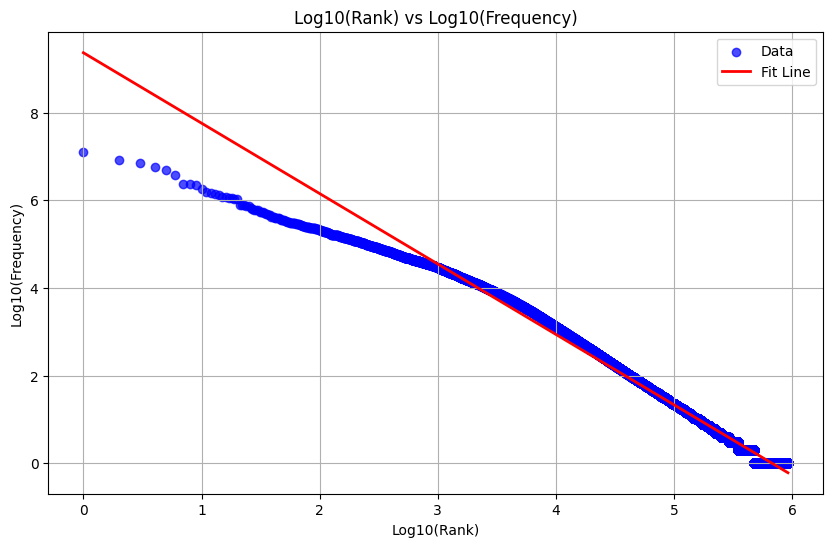

In [ ]:
# Prepare data for linear regression
X = sorted_df[['log10_index']].values  # Predictor (independent variable)
y = sorted_df['log10_frequency'].values  # Response (dependent variable)

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict values for the regression line
y_pred = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(sorted_df['log10_index'], sorted_df['log10_frequency'], alpha=0.7, c='blue', label='Data')
plt.plot(sorted_df['log10_index'], y_pred, color='red', linewidth=2, label='Fit Line')
plt.title('Log10(Rank) vs Log10(Frequency)')
plt.xlabel('Log10(Rank)')
plt.ylabel('Log10(Frequency)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Output the slope
display(Math(f'\\text{{Expected }} \\alpha \\text{{ is: }} {-model.coef_[0]}'))

<IPython.core.display.Math object>

# Task 4

##  Number of tokens and the vocabulary

In [ ]:
def process_chunk(chunk):
    tokens = chunk.split()  # Tokenize by splitting on whitespace
    return tokens

def read_in_chunks(file_path, chunk_size=1024*1024):  # 1MB chunks
    with open(file_path, 'r', encoding='utf-8') as f:
        while True:
            data = f.read(chunk_size)
            if not data:
                break
            yield data

def count_tokens_and_vocabulary(file_path):
    total_tokens = 0
    token_counter = Counter()

    with Pool(processes=cpu_count()) as pool:
        chunks = read_in_chunks(file_path)
        for tokens in tqdm(pool.imap_unordered(process_chunk, chunks), desc="Processing Chunks"):
            total_tokens += len(tokens)
            token_counter.update(tokens)

    return total_tokens, token_counter

In [ ]:
if __name__ == "__main__":
    output_file_path = '/content/dataset/corpus_cleaned.txt'
    total_tokens, token_counter = count_tokens_and_vocabulary(output_file_path)

    print(f"Number of tokens: {total_tokens}")
    print(f"Vocabulary size: {len(token_counter)}")

Processing Chunks: 1325it [01:20, 16.41it/s]


Number of tokens: 213451370
Vocabulary size: 1524671


# Task 5

##  Heaps’ empirical law

In [ ]:
# While iterating with the number of tokens, we keep track vocabulary into a pair (x,y)
def process_file(file_path):
    token_vocabulary_pairs = []

    vocabulary = set()

    token_count = 0

    with open(file_path, 'r', encoding='utf-8') as file:
        total_lines = sum(1 for _ in file)

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file, total=total_lines, desc="Processing tokens"):
            tokens = line.split()

            for token in tokens:
                token_count += 1
                vocabulary.add(token)
                token_vocabulary_pairs.append((token_count, len(vocabulary)))

    return token_vocabulary_pairs

In [ ]:
file_path = '/content/dataset/corpus_cleaned.txt'
pairs = process_file(file_path)

Processing tokens: 100%|██████████| 1986917/1986917 [01:44<00:00, 19044.87it/s]


In [ ]:
def plot_log_pairs(pairs):
    # Convert pairs to numpy arrays for easier manipulation
    print("Converting pairs to numpy arrays...")
    token_counts, vocab_sizes = zip(*pairs)

    # Convert to numpy arrays and calculate logarithms
    print("Calculating logarithms...")
    log_token_counts = np.log10(token_counts)
    log_vocab_sizes = np.log10(vocab_sizes)

    # Add a column of ones for the intercept term
    print("Setting up matrices for linear regression...")
    A = np.vstack([log_token_counts, np.ones(len(log_token_counts))]).T
    b = log_vocab_sizes

    # Perform linear regression and track progress
    print("Performing linear regression...")
    for _ in tqdm(range(1)):
        slope, intercept = np.linalg.lstsq(A, b, rcond=None)[0]

    # Generate fitted line values
    print("Generating fitted line values...")
    log_token_counts_range = np.linspace(min(log_token_counts), max(log_token_counts), 100)
    fitted_line = slope * log_token_counts_range + intercept

    print("Plotting the results...")
    plt.figure(figsize=(10, 6))
    plt.scatter(log_token_counts, log_vocab_sizes, s=1, alpha=0.5, label='Data points')
    plt.plot(log_token_counts_range, fitted_line, color='red', label='Fitted line')
    plt.xlabel('Log of Token Count')
    plt.ylabel('Log of Vocabulary Size')
    plt.title('Log-Log Plot of Token Count vs. Vocabulary Size')
    plt.grid(True)
    plt.legend()
    plt.show()

    return log_token_counts_range, fitted_line

Converting pairs to numpy arrays...
Calculating logarithms...
Setting up matrices for linear regression...
Performing linear regression...


100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


Generating fitted line values...
Plotting the results...


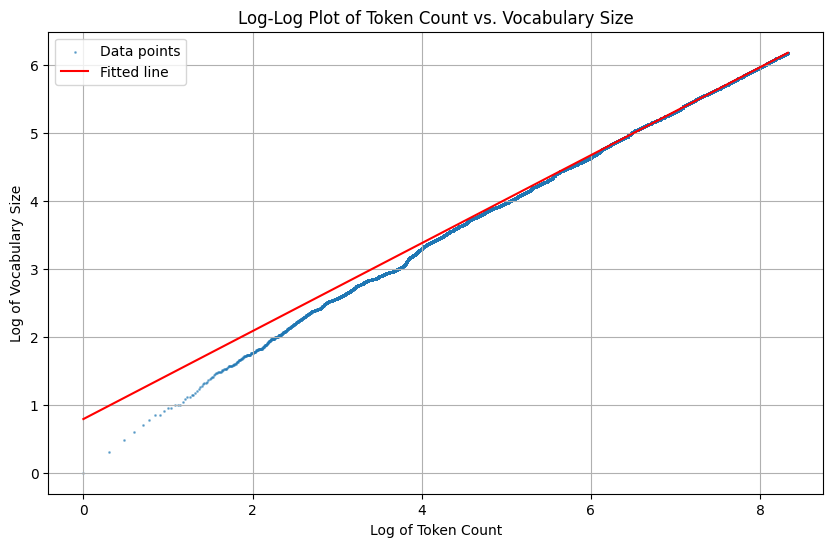

In [ ]:
count, line = plot_log_pairs(pairs)

In [ ]:
def extract_slope_intercept(log_token_counts_range, fitted_line):
    # Compute slope and intercept
    # Fit a line to the `log_token_counts_range` and `fitted_line` values
    A = np.vstack([log_token_counts_range, np.ones(len(log_token_counts_range))]).T
    slope, intercept = np.linalg.lstsq(A, fitted_line, rcond=None)[0]

    return slope, intercept

In [ ]:
slope, intercept = extract_slope_intercept(count,line)

 Heaps’ empirical law states \\
 $ V_{R}(n) = Kn^{β}$ \\
 where $ V_{R}(n)$ is the number of distinct words in an instance text of size n. K and β are free parameters determined empirically. Therefore, we can say \\
 $log(V_{R}(n)) = logK +βlogn$ \\
 Thus, from the line fitted above we can tell K and β values.

In [ ]:
print(f"β = {slope} \nK = {10 ** intercept}")

β = 0.6474172157189944 
K = 6.167647759543851


## Vocabulary count for every 10000 tokens.

In [ ]:
# For consecutive 10000 tokens we calculate the vocabulary
file_path = '/content/dataset/corpus_cleaned.txt'

# Chunk size
chunk_size = 10000

start = 0
end = chunk_size
vocab_size_list = []

# Open the file
with open(file_path, 'r') as file:
    text = file.read()

    tokens = text.split()

    while start < len(tokens):
        chunk_tokens = tokens[start:end]

        # Calculate vocabulary size for the current chunk
        vocab_size = len(set(chunk_tokens))
        vocab_size_list.append((f'{start + 1}-{end}', vocab_size))

        start = end
        end = start + chunk_size

vocab_df = pd.DataFrame(vocab_size_list, columns=['Token Range', 'Vocabulary Size'])

In [ ]:
vocab_df.head(50)

,Token Range,Vocabulary Size
0,1-10000,2011
1,10001-20000,2034
2,20001-30000,2072
3,30001-40000,2272
4,40001-50000,1960
5,50001-60000,2154
6,60001-70000,2193
7,70001-80000,1100
8,80001-90000,2236
9,90001-100000,1758
